### Imports

In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
import re
from transformers import BertTokenizer, BertForSequenceClassification,AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

2023-12-02 04:08:10.874096: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 04:08:10.997314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 04:08:10.997369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 04:08:11.012300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 04:08:11.047353: I tensorflow/core/platform/cpu_feature_guar

### Load data

In [2]:
chunk_size = 700000
json_file_path = "yelp_academic_dataset_review.json"

# Read the JSON file in chunks
chunks = pd.read_json(json_file_path, lines=True, chunksize=chunk_size)

for i, df_chunk in enumerate(chunks):
    print(f"Processing chunk {i + 1}")

    chunk_csv_path = f"chunk_{i + 1}.csv"
    df_chunk.to_csv(chunk_csv_path, index=False)
    df_chunk_from_csv = pd.read_csv(chunk_csv_path)

Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10


In [3]:
# Using the first 100000
chunk_size = 700000
file= "yelp_academic_dataset_review.json"

# Reading the JSON file in chunks
chunks1 = pd.read_json(file, lines=True, chunksize=chunk_size)

# Iterate over chunks and process each chunk
for i, x in enumerate(chunks1):
    print(f"Processing chunk {i + 1}")

    # Save the first chunk to a CSV file
    if i == 0:
        first_chunk_csv_path = "first_chunk.csv"
        x.to_csv(first_chunk_csv_path, index=False)

    df= pd.read_csv("first_chunk.csv")
    break

Processing chunk 1


In [4]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
699995,8nPFAHUg2Maq20h9PxHCSg,fM-DKqmd9Lh08bApyY-dsg,IHd8_cnLZe5oILE_oKy-5g,1,0,0,0,Do not go here! The only redeeming quality of ...,2015-05-23 23:16:41
699996,siyHQqTd-35kd9fEQkMskg,YYfgEK77PFL6-ErHHElHww,DvkSkF83xDONjkNIoEPRnQ,5,4,1,0,This place is amazing. I'm very surprised seei...,2017-07-12 19:57:37
699997,iuBOjA0J7B0_yT_3FEgUJQ,7h7SkRAIJMtynNSGntyxbw,Y3ZCO17N1_T_Ms1JmswwzA,4,0,0,0,"Horchata was good, and the tortillas were grea...",2016-11-15 23:50:18
699998,2WPcCACe-NecwIKDIRRPrA,qMdjazC9quXk6AElD3i9yA,f4vbnGoGo3eWorVekctVGQ,5,0,0,0,Best omelette and grits both my girlfriend and...,2015-12-29 17:38:16


### Visualization

In [5]:
# Data Preprocessing
texts = df['text']
labels = df['stars'].apply(lambda x: 1 if x > 3 else 0)  

In [6]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
699995,8nPFAHUg2Maq20h9PxHCSg,fM-DKqmd9Lh08bApyY-dsg,IHd8_cnLZe5oILE_oKy-5g,1,0,0,0,Do not go here! The only redeeming quality of ...,2015-05-23 23:16:41
699996,siyHQqTd-35kd9fEQkMskg,YYfgEK77PFL6-ErHHElHww,DvkSkF83xDONjkNIoEPRnQ,5,4,1,0,This place is amazing. I'm very surprised seei...,2017-07-12 19:57:37
699997,iuBOjA0J7B0_yT_3FEgUJQ,7h7SkRAIJMtynNSGntyxbw,Y3ZCO17N1_T_Ms1JmswwzA,4,0,0,0,"Horchata was good, and the tortillas were grea...",2016-11-15 23:50:18
699998,2WPcCACe-NecwIKDIRRPrA,qMdjazC9quXk6AElD3i9yA,f4vbnGoGo3eWorVekctVGQ,5,0,0,0,Best omelette and grits both my girlfriend and...,2015-12-29 17:38:16


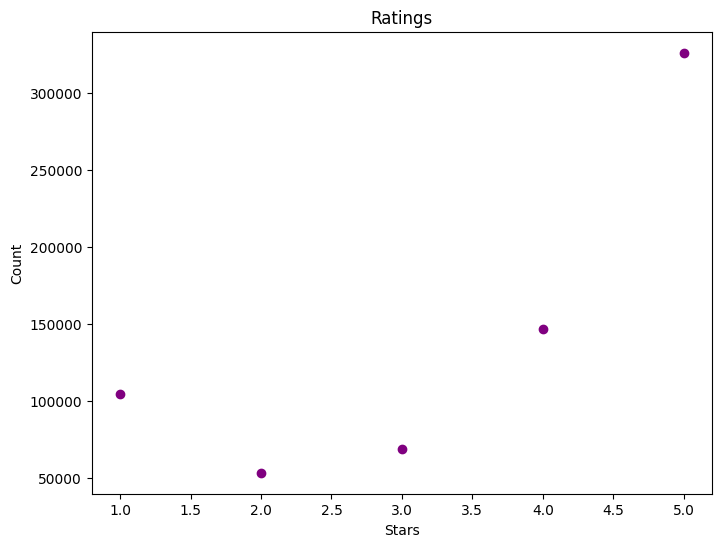

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(df['stars'].value_counts().sort_index().index, df['stars'].value_counts().sort_index(), color='purple')
plt.title('Ratings')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

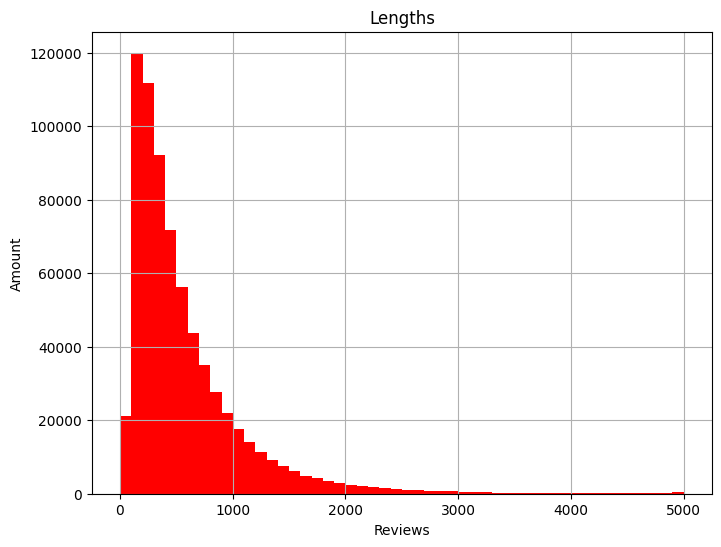

In [8]:
# Plot the distribution of review lengths
plt.figure(figsize=(8, 6))
df['review_length'] = df['text'].apply(len)
df['review_length'].hist(bins=50, color='red')
plt.title('Lengths')
plt.xlabel('Reviews')
plt.ylabel('Amount')
plt.show()

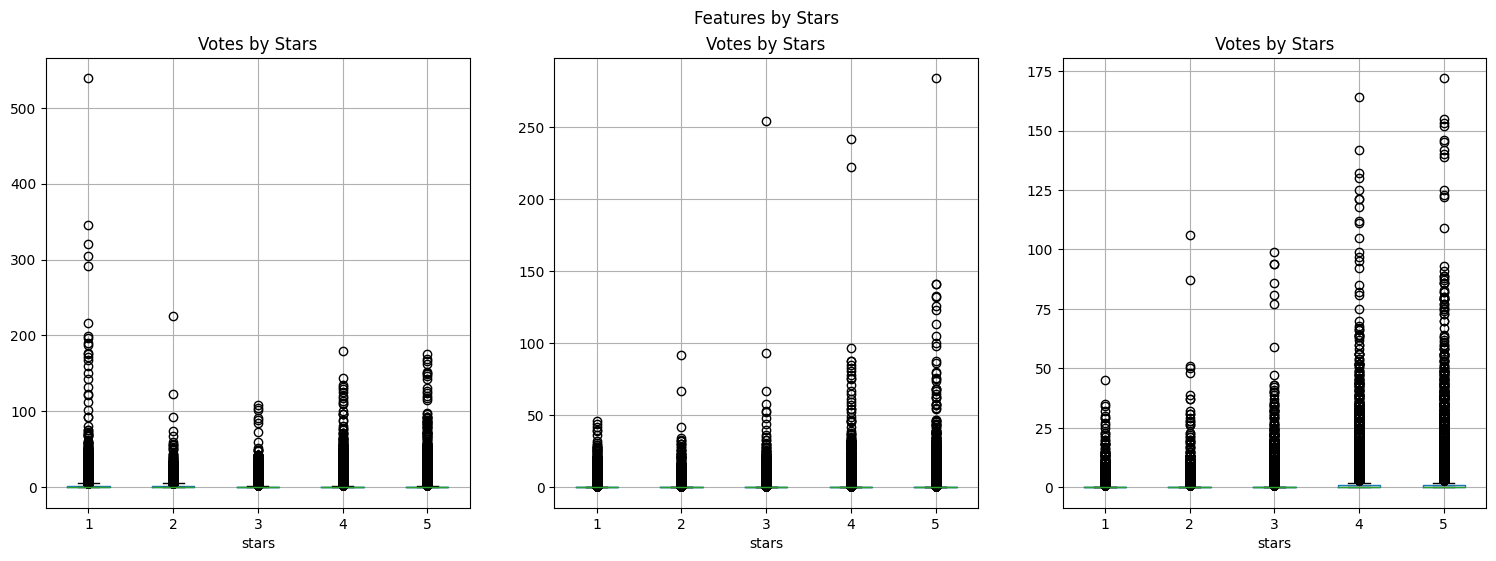

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

df.boxplot(column='useful', by='stars', ax=axes[0])
axes[0].set_title('Votes by Stars')

df.boxplot(column='funny', by='stars', ax=axes[1])
axes[1].set_title('Votes by Stars')

df.boxplot(column='cool', by='stars', ax=axes[2])
axes[2].set_title('Votes by Stars')

plt.suptitle('Features by Stars')
plt.show()

### Data Pre-processing

In [10]:
#### Drop duplicates
df = df.drop_duplicates(subset=['review_id'])
df = df.drop_duplicates(subset=['user_id'])
df = df.drop_duplicates(subset=['business_id'])
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,513
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,829
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,339
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,243
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,534
...,...,...,...,...,...,...,...,...,...,...
686552,t1GdeuIO_Mcw0E2oEU662w,7y3HeuIWJFoVRe-e9kAi3A,oDaamK_x-XhTOieP-qVvnw,5,1,0,1,Great selection of Mexican related food stuffs...,2014-01-11 13:00:46,103
689115,Xxr0VMnm0RnXlr5RSMt9HQ,sb3ZzGzoUECo64EZd6DE9g,cBbvS4klOQd221pKQVMGMA,4,2,0,0,Found some sweet deals on fruits!!! I came acr...,2019-11-14 00:13:54,163
693901,zMgZCG75QDYYCvKKrGGYfw,Q4-WQT0Q3_X4ZtCwDdfH_g,2FR-xWttfR8qaODqcuExvw,1,1,1,0,"I got one of those prepaid debit card ""Excepta...",2020-04-29 00:09:28,428
695069,bqYN3sifORSPnMIInqYgdg,kLPT0qfgHY5ppF2NbdPvlg,1q54Dq02nSFa9NFbu0Tbxw,1,3,0,0,"Absolute worst, most embarrassing experience o...",2019-04-28 15:00:37,894


In [11]:
# Remove Null values 
nulls= df.isnull().sum()
print("Nulls:\n", nulls)

Nulls:
 review_id        0
user_id          0
business_id      0
stars            0
useful           0
funny            0
cool             0
text             0
date             0
review_length    0
dtype: int64


In [12]:
import re
df['text'] = df['text'].apply(lambda x: re.sub(r'<.*?>', '', x))
##%%
# Remove special characters 
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [13]:
df['date'] = pd.to_datetime(df['date'])

### Tokenization

In [14]:
token = Tokenizer()
token.fit_on_texts(texts)
s = token.texts_to_sequences(texts)
index = token.word_index
maximumlength = 100  # Set your desired sequence length
data = pad_sequences(s, maxlen=maximumlength)

In [15]:
# Encode labels
l_encode = LabelEncoder()
labels = l_encode.fit_transform(labels)

### Train and Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.18, random_state=42)

### LSTM Model

In [18]:
model = Sequential()
model.add(Embedding(len(index) + 1, 100, input_length=maximumlength))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

### Compile the model

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the model

In [20]:
 # Training with Data Generator
def data_generator(data, labels, batch_size):
    samples = len(data)
    while True:
        s_indices = np.arange(samples)
        np.random.shuffle(s_indices)
        for i in range(0,samples, batch_size):
            b_indices = s_indices[i:i+batch_size]
            yield data[b_indices], labels[b_indices]

In [ ]:
batch_size = 33
epochs= len(X_train) // batch_size
# Training
model.fit(data_generator(X_train, y_train, batch_size),
          epochs=7,
          steps_per_epoch=epochs,
          validation_data=(X_test, y_test))       ######### Lizara

In [23]:
# Evaluation
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Accuracy: {accuracy*100}")

4375/4375 [==============================] - 36s 8ms/step - loss: 0.2269 - accuracy: 0.9234
Accuracy: 0.9234285950660706


In [24]:
# Evaluation
y_predicted_value = model.predict(X_test)
y_binary_value = (y_predicted_value > 0.5).astype(int)

4375/4375 [==============================] - 39s 9ms/step


In [25]:
# Metrics Calculation
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_binary_value, average='binary')

print(f"Precision score: {prec*100:.4f}")
print(f"Recall score: {rec*100:.4f}")
print(f"F1 Score: {f1*100:.4f}")

Precision: 0.9338
Recall: 0.9547
F1 Score: 0.9442


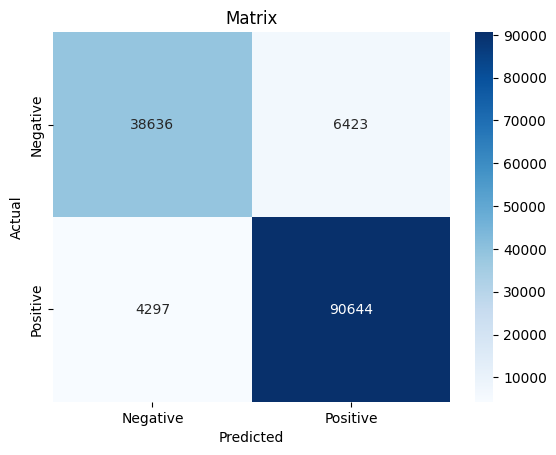

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_binary_value)

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

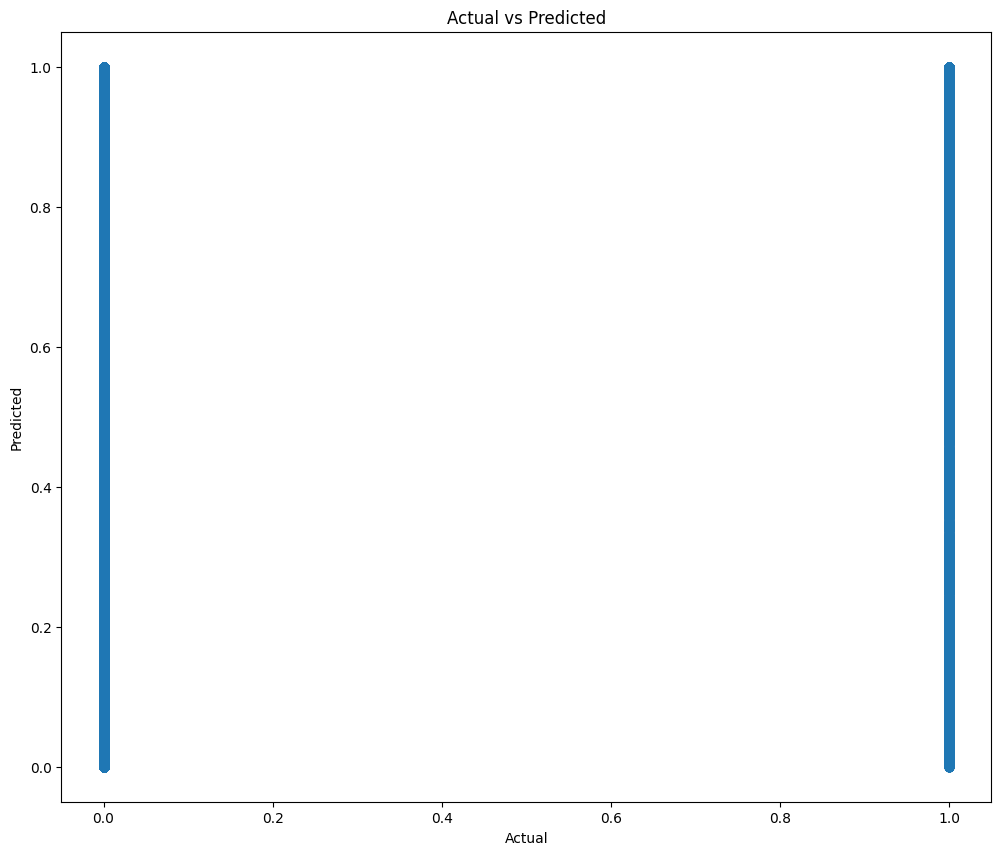

In [27]:
# Actual vs Predicted
plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_predicted_value, alpha=0.5)
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### Bert Super-vised


In [119]:
chunk= 100000
file= "yelp_academic_dataset_review.json"

chunks2 = pd.read_json(file, lines=True, chunksize=chunk)
for i, x in enumerate(chunks2):
    print(f"Processing chunk {i + 1}")
    if i == 0:
        csv = "chunk.csv"
        x.to_csv(csv, index=False)
    df1= pd.read_csv("chunk.csv")
    break

Processing chunk 1


In [120]:
def sentiment(stars):  
    if 0 <= stars < 3:
        return 0 #negative
    elif 3 <= stars <= 5:
        return 1 #normal
    else:
        return 'undefined'  

df1['sentiment_label'] = df1['stars'].apply(sentiment)
le = LabelEncoder()
df1['encoded_sentiment'] = le.fit_transform(df1['sentiment_label'])

# Extract labels
y = df1['encoded_sentiment'].values
df1.to_csv('preprocessed_data1.csv', index=False)

In [121]:
df1

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment_label,encoded_sentiment
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,1,1
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1,1
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,1,1
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1,1
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,pAEbIxvr6ebx2bHc1XvguA,SMH5CeiLvKx61lKwtLZ_PA,lV0k3BnslFRkuWD_kbKd0Q,4,0,0,0,Came here for lunch with a group. They were bu...,2018-05-30 22:28:56,1,1
99996,xH1AoE-4nf2ECGQJRjO4_g,2clTdtp-BjphxLjN83CpUA,G0xz3kyRhRi6oZl7KfR0pA,1,1,0,0,The equipment is so old and so felty! I just u...,2015-04-05 23:31:52,0,0
99997,GatIbXTz-WDru5emONUSIg,MRrN6DH3QGCFcDv5RENYVg,C4lZdhasjZVQyDlOiXY1sA,4,0,0,0,This is one of my favorite Mexican restaurants...,2016-06-04 00:59:15,1,1
99998,6NfkodAdhvI89xONXuBC3A,rnNQzeKJbvqVCsYsL10mkQ,dChRGpit9fM_kZK5pafNyA,2,0,0,0,Came here for brunch - had an omlette ($19 + t...,2018-06-11 12:45:08,0,0


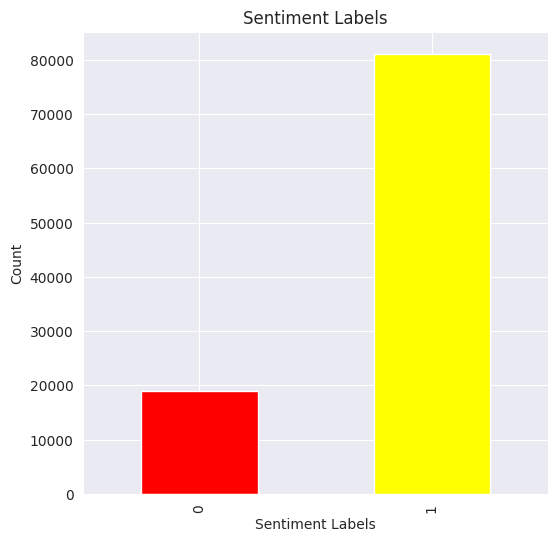

In [122]:
plt.figure(figsize=(6, 6))
df1['sentiment_label'].value_counts().sort_index().plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()

### Selecting divided parts

In [123]:
positive_reviews = df1[df1['sentiment_label'] == 1].sample(n=2000, random_state=42)
negative_reviews= df1[df1['sentiment_label'] == 0].sample(n=2000, random_state=42)

# Combine the selected samples
new_data = pd.concat([positive_reviews, negative_reviews], ignore_index=True)

In [124]:
new_data

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment_label,encoded_sentiment
0,LP2B6aJarFIJ7I6BJ1cD9A,QY1R3IciPr-IkKeTFsqVOA,Di6uZDhcwnLsgM66Z4fNfw,5,0,0,0,The type of bar a vigilante would go to after ...,2018-03-05 00:04:30,1,1
1,mHShP4zIYe1D2S-EBJOGIw,xFj_h72vn0th96ETHQUY7A,rZceWBN1i0QMmmXJcJLfxw,3,6,1,1,This place is OK the therapist my son has is w...,2015-11-09 19:21:43,1,1
2,2Ok8SYfDBlYi8kckknqEUA,huoocXS_i6g65qESKMo7gQ,4NidY2tw42l6iobbtai_kA,3,0,0,0,Really prompt service even though we were 30 m...,2018-01-01 02:41:07,1,1
3,3YGWryyrTbDH0fiCn4OHBQ,Q3E9uqEA0kcgkkjju6h1KQ,wzIN0IqcNOnUjwuzRoG9AA,5,0,0,0,"I got the pick 3! Had the stuffed pepper , jam...",2018-07-28 23:09:42,1,1
4,ZYbM8Y34-okwn--e5kiO1g,FtZ2rivohSn-KIj_8138yQ,USekrAG0-4tJUs9V2gBBOQ,5,0,0,0,Fantastic! \n\nStaff was amazingly friendly. ...,2016-07-27 22:12:07,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3995,WpMd2rE9H3Z_Fp38i9OMFw,yjGTXXUjzpR8Q25ZKcKwXw,8usO-H5uFTzlISfGZN8rSg,2,4,1,0,"The food was good, but that was the only thing...",2015-07-28 20:36:17,0,0
3996,xDKP0idPe3I2zGZTocGa4A,-kMtxnQmE_S3_U1yZ2cVtQ,eaV07HGOcyb27XobHVl8LQ,1,3,0,1,"So basically, you are going to be having a stu...",2012-09-10 19:52:09,0,0
3997,KmVnM35HQR7sEun610gsag,OZ-T-UTOXUXva4RJ8j61oQ,qcLkiAqlxx0oTqZMSC_y6Q,1,4,1,0,Absolutely the worst hair cut I have ever seen...,2015-12-23 16:45:43,0,0
3998,P_NZRZPHP3k-HnYacdUtwQ,KGdV17WL4x2w52VK81D_Iw,SRb3xScVOeYfhZP4U8LMdA,2,0,0,0,"Unfortunately, the other reviews said it all. ...",2015-07-29 00:28:15,0,0


#### Load model and tokenizer

In [125]:
from transformers import BertTokenizer, BertForSequenceClassification 
model_name = "bert-base-uncased"
# tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)
# Model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Tokenizer

In [126]:
# Tokenize the texts (reviews)
import torch

tokenized_vals = []

for text in new_data['text']:
    tokens = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128, 
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    # Append individually
    tokenized_vals.append({
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask']
    })

# Extracting input tensors separately
input_ids = torch.cat([entry['input_ids'] for entry in tokenized_vals], dim=0)
attention_mask = torch.cat([entry['attention_mask'] for entry in tokenized_vals], dim=0)


#### Train and test split

In [127]:
label = new_data['encoded_sentiment']

In [128]:
X_train_id, X_test_id, X_train_m, X_test_m, y_train, y_test = train_test_split(
    input_ids.numpy(),
    attention_mask.numpy(),
    label,
    test_size=0.15,
    random_state=42
)

In [129]:
print(X_train_id.shape, X_test_id.shape, X_train_m.shape, X_test_m.shape, y_train.shape, y_test.shape)

(3400, 128) (600, 128) (3400, 128) (600, 128) (3400,) (600,)


In [130]:
# PyTorch tensors 
X_train_ids= torch.tensor(X_train_id, dtype=torch.long)
X_test_ids= torch.tensor(X_test_id, dtype=torch.long)
X_train_mask= torch.tensor(X_train_m, dtype=torch.long)
X_test_mask= torch.tensor(X_test_m, dtype=torch.long)
y_train= torch.tensor(y_train.values, dtype=torch.long) 
y_test= torch.tensor(y_test.values, dtype=torch.long)  

### Loading optimizer

In [131]:
criter = torch.nn.CrossEntropyLoss()   
optim= torch.optim.AdamW(model.parameters(), lr=5e-5)

### Training the model

In [132]:
epochs = 3
batch_size = 3

train_data = TensorDataset(X_train_ids, X_train_mask, y_train)
test_data = TensorDataset(X_test_ids, X_test_mask, y_test)

train_load = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_load= DataLoader(test_data,batch_size=batch_size, shuffle=True)

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_load:
        inputs, attention_mask, label = batch
        optim.zero_grad()

        if label is not None:
            print("Working")
            batch_output= model(inputs, attention_mask=attention_mask, labels=label)
            loss = batch_output.loss
            total_loss += loss.item()

            # Backpropagation and optimization
            loss.backward()
            optim.step()
            print("Outputs:", batch_output)

    print(f"Epoch {epoch + 1}/{epochs}, Loss_per_epoch: {total_loss}")
# Save the model
torch.save(model.state_dict(), 'model.pth')                  ############################## Abdul

### Load the model

In [18]:
save_model= BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
save_model.load_state_dict(torch.load('model.pth'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

#### Train on test data

In [19]:
save_model.eval()  
with torch.no_grad(): 
    total= 0
    actual_pred = 0

    for batch in test_load:
        inputs, attention_mask, labels = batch
        print(f"Working: {total+ 1}/{len(test_load)}")

        test_predictions = save_model(inputs, attention_mask=attention_mask)
        _, predicted= torch.max(test_predictions.logits, 1)
        actual_pred += (predicted== labels).sum().item()
        total+= labels.size(0)

    accuracy = actual_pred / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Evaluating Batch: 1/200
Evaluating Batch: 4/200
Evaluating Batch: 7/200
Evaluating Batch: 10/200
Evaluating Batch: 13/200
Evaluating Batch: 16/200
Evaluating Batch: 19/200
Evaluating Batch: 22/200
Evaluating Batch: 25/200
Evaluating Batch: 28/200
Evaluating Batch: 31/200
Evaluating Batch: 34/200
Evaluating Batch: 37/200
Evaluating Batch: 40/200
Evaluating Batch: 43/200
Evaluating Batch: 46/200
Evaluating Batch: 49/200
Evaluating Batch: 52/200
Evaluating Batch: 55/200
Evaluating Batch: 58/200
Evaluating Batch: 61/200
Evaluating Batch: 64/200
Evaluating Batch: 67/200
Evaluating Batch: 70/200
Evaluating Batch: 73/200
Evaluating Batch: 76/200
Evaluating Batch: 79/200
Evaluating Batch: 82/200
Evaluating Batch: 85/200
Evaluating Batch: 88/200
Evaluating Batch: 91/200
Evaluating Batch: 94/200
Evaluating Batch: 97/200
Evaluating Batch: 100/200
Evaluating Batch: 103/200
Evaluating Batch: 106/200
Evaluating Batch: 109/200
Evaluating Batch: 112/200
Evaluating Batch: 115/200
Evaluating Batch: 118/

In [2]:
chunk= 100
file= "yelp_academic_dataset_review.json"

chunks1 = pd.read_json(file, lines=True, chunksize=chunk)

# Iterate over chunks and process each chunk
for i, x in enumerate(chunks1):
    print(f"Processing chunk {i + 1}")

    # Save the first chunk to a CSV file
    if i == 0:
        csv= "chunk.csv"
        x.to_csv(csv, index=False)

    df2= pd.read_csv("chunk.csv")
    break

Processing chunk 1


### Using Roberta for unsupervised Learning

In [3]:
from transformers import RobertaTokenizer, RobertaModel
import torch
from sklearn.cluster import KMeans
import pandas as pd

text_data = df2['text'].tolist()

### Tokenization

In [4]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
text_encode = tokenizer(text_data, padding=True, truncation=True, return_tensors='pt')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Embedding

In [5]:
with torch.no_grad():
    outputs = model(**text_encode)
    embeddings_data = outputs.last_hidden_state.mean(dim=1).numpy()

### Plotting and finding PCA components

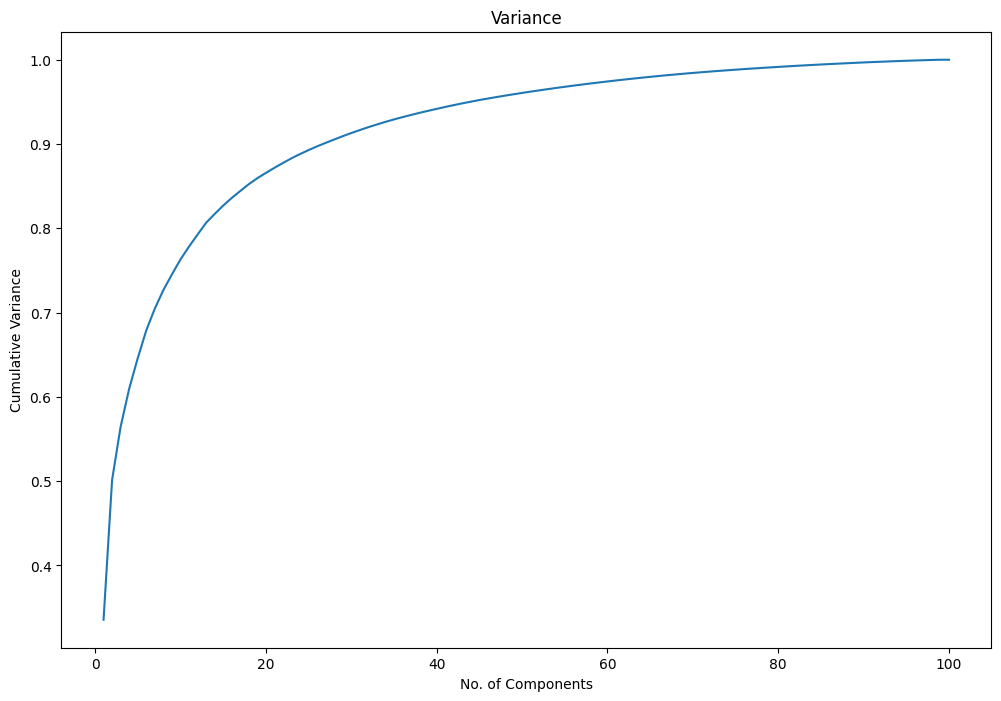

In [6]:
pca = PCA()
pca.fit(embeddings_data)

plt.figure(figsize=(12, 8))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_) + 1), y=np.cumsum(pca.explained_variance_ratio_))
plt.title('Variance')
plt.xlabel('No. of Components')
plt.ylabel('Cumulative Variance')
plt.show()

### Using elbow method to decide the number of components

In [7]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
elbow_index = np.argmax(np.diff(cumulative_var) < 0.01)

In [8]:
components = elbow_index + 1
print(f"Number of Components: {components}")

Number of Components: 14


### Applying PCA with 14 components

In [9]:
pca = PCA(n_components=14)  # Adjust the number of components as needed
embeddings_pca = pca.fit_transform(embeddings_data)

### Scaling

In [10]:
scaler = MinMaxScaler()
embeddings_scaled = scaler.fit_transform(embeddings_pca)

### Clustering using Kmeans

In [11]:
kmeans = KMeans(n_clusters=2)  # Positive and Negative
clusters = kmeans.fit_predict(embeddings_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
df2['Cluster_pred'] = clusters
# Print the DataFrame with predicted clusters
df2[['text', 'Cluster_pred']]

,text,Cluster_pred
0,"If you decide to eat here, just be aware it is...",1
1,I've taken a lot of spin classes over the year...,0
2,Family diner. Had the buffet. Eclectic assortm...,1
3,"Wow! Yummy, different, delicious. Our favo...",1
4,Cute interior and owner (?) gave us tour of up...,1
...,...,...
95,Had to wait until my third trip to NOLA to act...,0
96,A GREAT EXPERIENCE!!!!!!!!! I was a completel...,0
97,Wow! I never thought my sons phone could be re...,0
98,Service and management terrible... After messi...,1


In [13]:
print(df2['Cluster_pred'].unique())

[1 0]


In [14]:
def sentiment(stars):  #Ashken
    if 0 <= stars <3:
        return 0 #negative
    elif 3<= stars <= 5:
        return 1 #positive

df2['sentiment_label'] = df2['stars'].apply(sentiment)

In [15]:
df2

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,Cluster_pred,sentiment_label
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,1,1
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,0,1
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,1,1
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1,1
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1,1
...,...,...,...,...,...,...,...,...,...,...,...
95,QS7CuOtFLuS3dnwKHRtSYQ,PBnEwGVCBL0N-bET6ZI6kQ,m5-FtgWRd4qA7j0vaOXiXQ,5,0,0,0,Had to wait until my third trip to NOLA to act...,2016-11-10 20:56:13,0,1
96,4PHFo_GRG4FEk1q4X7xQVQ,jbsCBG0A-3wVDjrKar-0Wg,X63jIMRHYBvKKQDuJTRiQQ,5,2,0,1,A GREAT EXPERIENCE!!!!!!!!! I was a completel...,2014-10-11 13:55:05,0,1
97,1c6sgLe07HAhipebsQ1wgA,ZRXvbrutBBULaFS6T9NCwA,HnhxO2cpa15AHI1456Pl6Q,5,0,1,0,Wow! I never thought my sons phone could be re...,2015-10-17 00:55:35,0,1
98,PPgbLBvi34A6m7bKJfTwhw,3TL6HZ1JrKcNTvGDWKlrow,GyC36Pn0Q1-qHnqXys6yFg,1,0,0,0,Service and management terrible... After messi...,2013-12-07 13:17:13,1,0


### Comparison with labelled set

In [16]:
true_labels = df2['sentiment_label'].tolist()

# encoding
label_encoder = LabelEncoder()
encoded1 = label_encoder.fit_transform(true_labels)

# Calculate accuracy
accuracy = accuracy_score(encoded1, clusters)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 51.00%


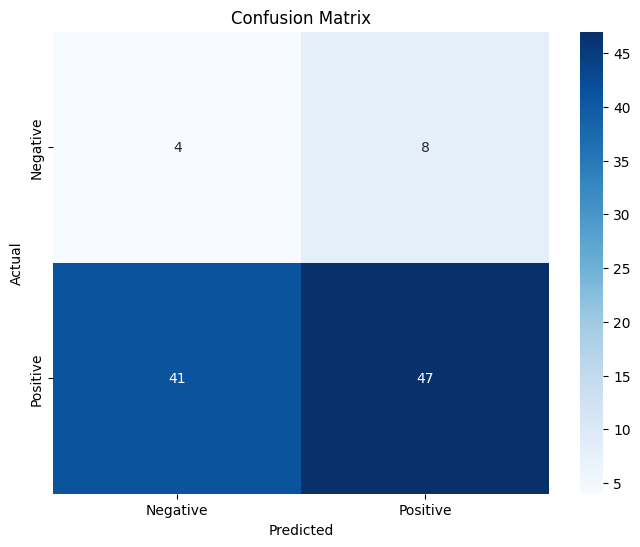

In [17]:
# Plotting a confusion matrix
conf_matrix = confusion_matrix(encoded1, clusters)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
# Printing a classification report
report = classification_report(encoded1, clusters, target_names=['Negative', 'Positive'])
print("Report:\n", report)

Report:
               precision    recall  f1-score   support

    Negative       0.09      0.33      0.14        12
    Positive       0.85      0.53      0.66        88

    accuracy                           0.51       100
   macro avg       0.47      0.43      0.40       100
weighted avg       0.76      0.51      0.60       100
